MMSE Filter Coefficients:
 [ 1.22183877e-03-0.00457448j  5.58248498e-03+0.0109104j
 -5.44517378e-03-0.01092597j  6.20215988e-03-0.00542597j
 -5.15848227e-03+0.00597098j  8.25472939e-03-0.00702219j
 -8.70224127e-03+0.00835409j  2.52015797e-03-0.01247676j
 -7.04185199e-04+0.00958267j -6.83053049e-03-0.01054348j
  2.02932727e-02-0.00119397j -4.13922045e-02+0.00203988j
  8.45734342e-02-0.00361327j  8.04123672e-01+0.00361605j
 -2.91226401e-01-0.00473329j]


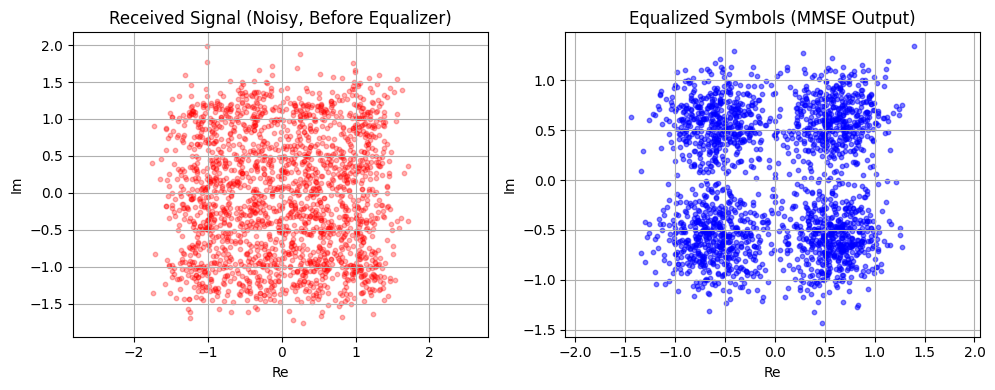

In [6]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# 1) PARAMETERS
###############################################################################

M = 4               # QAM order (4-QAM => QPSK)
num_symbols = 2000  # Number of training symbols
snr_dB = 10         # Signal-to-Noise Ratio in dB
filter_len = 15      # Length of MMSE equalizer
channel = np.array([1.0, 0.5])  # Example channel: h[0]=1, h[1]=0.5

# Choose a "training" delay inside the filter
# This is the tap index where we want the main symbol to align
delay = 1

###############################################################################
# 2) GENERATE TRANSMITTED DATA (TRAINING)
###############################################################################

# Generate random symbols in {0,1,2,3} for 4-QAM
tx_bits = np.random.randint(0, M, num_symbols)

# Map to QPSK (4-QAM) constellation with average power = 1
# For QPSK: (0->(+1,+1)), (1->(+1,-1)), (2->(-1,+1)), (3->(-1,-1)), etc.
# A simple approach:
symbols = (2*(tx_bits % 2)-1) + 1j*(2*(tx_bits // 2)-1)
symbols /= np.sqrt(2)  # Normalize so average symbol power ~ 1

###############################################################################
# 3) PASS THROUGH CHANNEL + ADD NOISE
###############################################################################

# Convolve with channel
rx_channel = np.convolve(symbols, channel, mode='full')

# Add AWGN
signal_power = np.mean(np.abs(rx_channel)**2)
snr_linear = 10**(snr_dB/10)
noise_power = signal_power / snr_linear
noise = np.sqrt(noise_power/2)*(np.random.randn(len(rx_channel))
                                + 1j*np.random.randn(len(rx_channel)))
rx_noisy = rx_channel + noise

###############################################################################
# 4) FORM THE DATA MATRIX (X) AND DESIRED RESPONSE (d)
###############################################################################
# We'll build a matrix X of size (num_samples x filter_len),
# where each row is [x(u), x(u-1), ..., x(u-filter_len+1)].
# The desired output d[u] = transmitted symbol (with the chosen delay).

# Because the channel extends the signal length, define "valid" region
num_valid = len(rx_noisy) - (filter_len - 1)
# We only train on the first num_valid points.

X = np.zeros((num_valid, filter_len), dtype=complex)
d = np.zeros(num_valid, dtype=complex)

for u in range(num_valid):
    # The "current" sample is rx_noisy[u + (filter_len - 1)]
    # We'll fill row u with [ x(u+4), x(u+3), ..., x(u) ] if filter_len=5
    for k in range(filter_len):
        X[u, k] = rx_noisy[u + (filter_len - 1) - k]

    # Desired symbol aligns with the symbol that *ideally* lands at 'delay'
    # If the filter final output is at index "u + (filter_len - 1)",
    # we want the transmitted symbol for index (u + delay)
    idx_symbol = u + delay
    if idx_symbol < len(symbols):
        d[u] = symbols[idx_symbol]
    else:
        d[u] = 0.0  # out-of-range => no data

###############################################################################
# 5) MMSE SOLUTION: w = (X^H X + sigma^2 I)^(-1) (X^H d)
###############################################################################

# Estimate noise variance or assume known
# A rough approach is to measure total power and subtract channel-based power
# For simplicity, let's approximate from SNR directly:
sigma_n2 = noise_power  # noise variance

# Autocorrelation matrix R_xx ~ X^H * X
R_xx = X.conj().T @ X

# Cross-correlation vector r_xd ~ X^H * d
r_xd = X.conj().T @ d

# Regularize with noise variance on the diagonal (MMSE vs. ZF)
w_mmse = np.linalg.inv(R_xx + sigma_n2 * np.eye(filter_len)) @ r_xd

print("MMSE Filter Coefficients:\n", w_mmse)

###############################################################################
# 6) APPLY THE MMSE FILTER TO (OPTIONAL) TEST DATA OR THE SAME TRAINING DATA
###############################################################################

# Let's just apply it to the entire rx_noisy to see the "equalized" output
# We'll convolve in discrete time: y[u] = sum_{k=0..filter_len-1} w_mmse[k]*x[u-k]
y_mmse = np.zeros_like(rx_noisy, dtype=complex)

for u in range(len(rx_noisy)):
    # sum over filter_len taps
    acc = 0+0j
    for k in range(filter_len):
        idx = u - k
        if idx >= 0 and idx < len(rx_noisy):
            acc += w_mmse[k]*rx_noisy[idx]
    y_mmse[u] = acc

# We expect the best symbol decisions around a delay offset
# of about "delay" from the original symbol indices

###############################################################################
# 7) EVALUATION / PLOTTING
###############################################################################

# For simplicity, let's just plot the equalized constellation for
# the main region (where we have valid symbols).
# The "decision" index for symbol m is m + (filter_len-1 - delay).
dec_indices = np.arange(num_symbols) + (filter_len - 1 - delay)
dec_indices = dec_indices[(dec_indices >= 0) & (dec_indices < len(y_mmse))]

equalized_symbols = y_mmse[dec_indices]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Received Signal (Noisy, Before Equalizer)")
plt.scatter(rx_noisy.real, rx_noisy.imag, color='r', alpha=0.3, s=10)
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True)
plt.axis('equal')

plt.subplot(1,2,2)
plt.title("Equalized Symbols (MMSE Output)")
plt.scatter(equalized_symbols.real, equalized_symbols.imag, color='b', alpha=0.5, s=10)
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()


## Scenario with RRC

MMSE Filter Coeffs:
 [-0.14684704+0.00754265j  0.48533763-0.00774004j  0.34865337+0.00626632j
 -0.13768345-0.007199j    0.09243114+0.007473j   -0.07177715-0.00951221j
  0.06397182+0.01293031j -0.06022602-0.00516805j  0.04733532+0.00718316j
 -0.03939671-0.00687192j  0.03348735+0.00781963j -0.02804979-0.0052785j
  0.02271478+0.0022808j  -0.01552477-0.00509144j  0.01273336+0.00222107j]


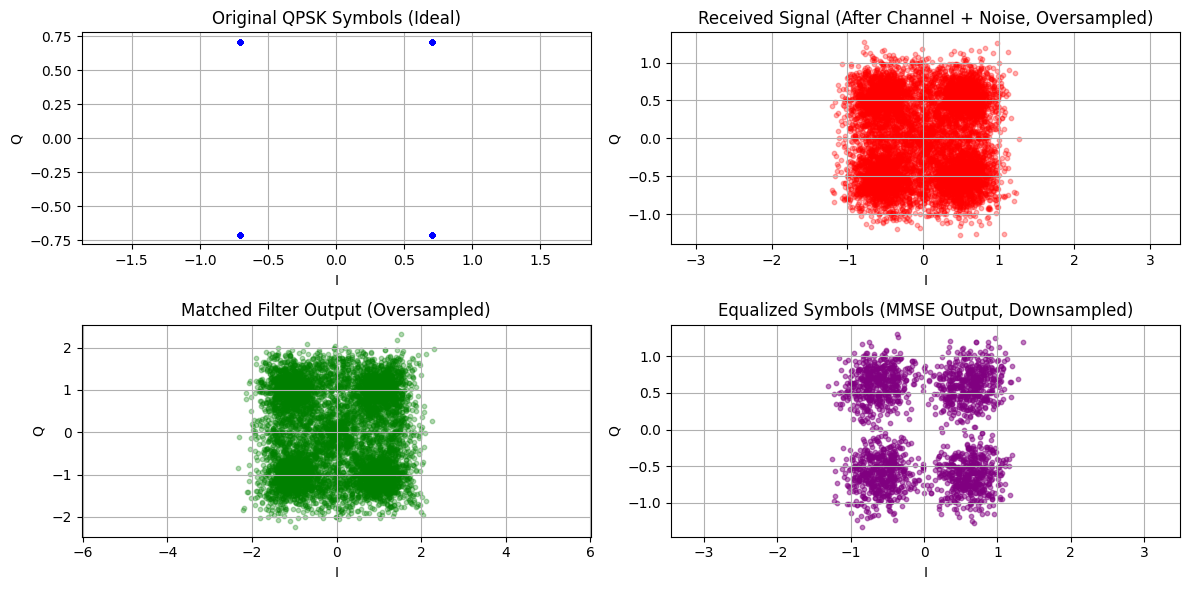

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

###############################################################################
# 1) HELPER FUNCTION: RRC FILTER
###############################################################################
def rrc_filter(rolloff, span, sps):
    """
    Generate a Root Raised Cosine (RRC) filter.

    :param rolloff: Rolloff factor (0 <= rolloff <= 1).
    :param span:    Filter span in symbols.
    :param sps:     Samples per symbol (oversampling factor).
    :return:        1-D numpy array of filter taps.
    """
    # Filter half-length in symbol durations
    N = span * sps
    t = np.arange(-N, N+1, dtype=float) / sps  # in symbol-time units

    # Avoid division by zero
    h = np.zeros_like(t)
    for i, val in enumerate(t):
        if val == 0.0:
            # Limiting case
            h[i] = 1.0 - rolloff + 4*rolloff/np.pi
        elif abs(4*rolloff*val) == 1:
            # Another special case
            numerator = (1 + 2/np.pi)*np.sin(np.pi/(4*rolloff)) \
                        + (1 - 2/np.pi)*np.cos(np.pi/(4*rolloff))
            denominator = np.sqrt(2)
            h[i] = (rolloff / denominator) * numerator
        else:
            # General formula
            numerator = np.sin(np.pi*val*(1-rolloff)) \
                        + 4*rolloff*val*np.cos(np.pi*val*(1+rolloff))
            denominator = np.pi*val*(1 - (4*rolloff*val)**2)
            h[i] = numerator / denominator

    # Normalize energy
    h /= np.sqrt(np.sum(h**2))
    return h

###############################################################################
# 2) PARAMETERS
###############################################################################
M            = 4                # 4-QAM (QPSK)
num_symbols  = 2000             # Number of symbols
sps          = 4                # Samples per symbol for up/down sampling
rolloff      = 0.25             # RRC rolloff
span         = 6                # RRC filter span in symbols
snr_dB       = 10               # SNR in dB
filter_len   = 15               # MMSE filter length (symbol-spaced!)
channel      = np.array([1.0, 0.5])  # Simple 2-tap channel
delay        = 2                # Desired symbol delay in the MMSE filter

###############################################################################
# 3) TRANSMITTER WITH RRC
###############################################################################
np.random.seed(42)  # for reproducibility

# Generate random 4-QAM (QPSK) symbols in {0,1,2,3}
tx_bits = np.random.randint(0, M, num_symbols)

# Map to QPSK: (+/-1 +/-1j)/sqrt(2)
symbols = (2*(tx_bits % 2) - 1) + 1j*(2*(tx_bits // 2) - 1)
symbols /= np.sqrt(2)  # average power = 1

# RRC pulse shape
h_rrc = rrc_filter(rolloff, span, sps)

# Upsample the symbols: place each symbol at index k*sps
upsampled = np.zeros(num_symbols*sps, dtype=complex)
upsampled[::sps] = symbols

# Transmit pulse shaping
tx_signal = convolve(upsampled, h_rrc, mode='full')

###############################################################################
# 4) CHANNEL + NOISE
###############################################################################
# Convolve with channel
rx_channel = convolve(tx_signal, channel, mode='full')

# Add AWGN
signal_power = np.mean(np.abs(rx_channel)**2)
snr_linear   = 10**(snr_dB/10)
noise_power  = signal_power / snr_linear
noise        = np.sqrt(noise_power/2) * (np.random.randn(len(rx_channel))
                                         + 1j*np.random.randn(len(rx_channel)))
rx_noisy     = rx_channel + noise

###############################################################################
# 5) MATCHED FILTER & DOWN-SAMPLING
###############################################################################
# Matched filter with same RRC
rx_matched = convolve(rx_noisy, h_rrc, mode='full')

# Symbol timing offset:
#   We typically skip the initial transients: ~ span*sps
offset = span  # (try adjusting if needed)
# Downsample at symbol rate:
rx_downsampled = rx_matched[offset::sps]

# Now rx_downsampled should have ~ (num_symbols + some extra) samples
# We want at least 'num_symbols' of them to align with the original symbol times.

###############################################################################
# 6) FORM THE DATA MATRIX (X) AND DESIRED RESPONSE (d) FOR MMSE
###############################################################################
# We'll do a symbol-spaced MMSE. The channel + RRC is about 2*(span) + len(channel)-1 extra in length.

num_valid = len(rx_downsampled) - (filter_len - 1)
train_len = min(num_symbols, num_valid)  # we only train on these many

X = np.zeros((train_len, filter_len), dtype=complex)
d = np.zeros(train_len, dtype=complex)

for u in range(train_len):
    # row u => samples [rx_downsampled[u + (filter_len-1)], ..., rx_downsampled[u]]
    for k in range(filter_len):
        idx = u + (filter_len - 1) - k
        if 0 <= idx < len(rx_downsampled):
            X[u, k] = rx_downsampled[idx]
        else:
            X[u, k] = 0

    # Desired symbol => original symbol at index (u + delay)
    # Because we want the main peak at tap 'delay'
    sym_idx = u + delay
    if sym_idx < num_symbols:
        d[u] = symbols[sym_idx]
    else:
        d[u] = 0  # out of range

###############################################################################
# 7) MMSE SOLUTION
###############################################################################
sigma_n2 = noise_power  # approximate noise variance

R_xx = X.conj().T @ X
r_xd = X.conj().T @ d

w_mmse = np.linalg.inv(R_xx + sigma_n2*np.eye(filter_len)) @ r_xd

print("MMSE Filter Coeffs:\n", w_mmse)

###############################################################################
# 8) APPLY THE SYMBOL-SPACED MMSE FILTER
###############################################################################
# We'll convolve w_mmse with rx_downsampled
y_mmse = np.convolve(rx_downsampled, w_mmse, mode='full')

# We pick out the symbol decisions at index k + (filter_len - 1 - delay)
dec_indices = np.arange(num_symbols) + (filter_len - 1 - delay)
dec_indices = dec_indices[(dec_indices >= 0) & (dec_indices < len(y_mmse))]

equalized_symbols = y_mmse[dec_indices]

###############################################################################
# 9) PLOTTING
###############################################################################
plt.figure(figsize=(12,6))

# (A) Transmit Constellation (the ideal QPSK symbols, just for reference)
plt.subplot(2,2,1)
plt.title("Original QPSK Symbols (Ideal)")
plt.scatter(symbols.real, symbols.imag, color='blue', alpha=0.5, s=10)
plt.grid(True)
plt.xlabel("I")
plt.ylabel("Q")
plt.axis('equal')

# (B) Received Noisy (Oversampled)
plt.subplot(2,2,2)
plt.title("Received Signal (After Channel + Noise, Oversampled)")
plt.scatter(rx_noisy.real, rx_noisy.imag, color='red', alpha=0.3, s=10)
plt.grid(True)
plt.xlabel("I")
plt.ylabel("Q")
plt.axis('equal')

# (C) After Matched Filter (Still Oversampled)
plt.subplot(2,2,3)
plt.title("Matched Filter Output (Oversampled)")
plt.scatter(rx_matched.real, rx_matched.imag, color='green', alpha=0.3, s=10)
plt.grid(True)
plt.xlabel("I")
plt.ylabel("Q")
plt.axis('equal')

# (D) After MMSE Equalizer (Symbol-Spaced)
plt.subplot(2,2,4)
plt.title("Equalized Symbols (MMSE Output, Downsampled)")
plt.scatter(equalized_symbols.real, equalized_symbols.imag, color='purple', alpha=0.5, s=10)
plt.grid(True)
plt.xlabel("I")
plt.ylabel("Q")
plt.axis('equal')

plt.tight_layout()
plt.show()
